In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

Carga de bases de datos disponible en Gluonts

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


Descargar la base de datos

In [4]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /Users/sergiocalderon/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /Users/sergiocalderon/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


Conjunto de entrenamiento

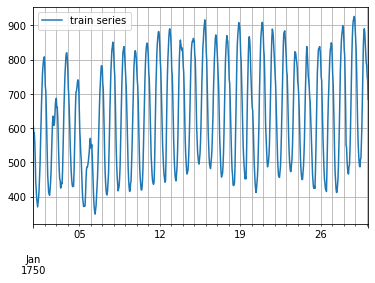

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

Conjunto de prueba

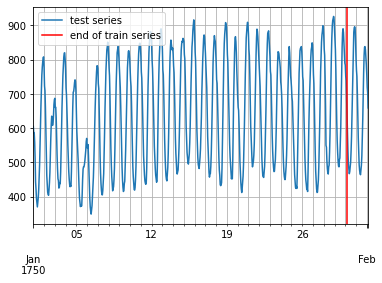

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

Metadata

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Ejemplo forma Conjunto de Datos

GluonTs requiere que el conjunto de datos tenga un conjunto que sea iterable, además debe tener un campo "target", que indica el horizonte de pronóstico y "start" el inicio del periodo muestral.

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [9]:
from gluonts.dataset.common import ListDataset

Divide en entrenamiento y prueba, al igual que se agregan los campos target y start.

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

In [11]:
train_ds

In [12]:
test_ds

In [13]:
custom_dataset.shape

(10, 100)

In [14]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

Definición del modelo, una red neuronal MLP

In [15]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [16]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:00<00:00, 146.31it/s, epoch=5/5, avg_epoch_loss=4.75]


In [17]:
from gluonts.evaluation import make_evaluation_predictions

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [19]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [20]:
# first entry of the time series list
ts_entry = tss[0]

In [21]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [22]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [23]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [24]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [25]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [26]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [656.20044 568.2429  469.7095  458.65872 533.0124  442.59137 521.58655
 462.5029  405.05215 531.61786 617.85626 646.11945 763.39154 783.6897
 945.40765 841.64044 925.18945 819.4963  861.71405 848.6459  742.5775
 906.94055 796.6461  723.3887  637.56006 634.9682  516.65186 446.0668
 523.63983 526.33826 453.6541  519.12366 472.51157 632.7169  541.3562
 713.65375 804.19086 799.46906 911.82385 911.7185  839.5971  879.457
 921.97296 806.7408  936.9861  791.5185  673.7882  713.5334 ]
0.5-quantile (median) of the future window:
 [648.87555 595.75726 461.77264 451.90768 527.02295 454.64124 522.3965
 452.76688 387.15152 538.7156  604.3316  657.41766 779.32074 775.9848
 934.5393  846.6129  944.82983 825.5028  869.5624  851.406   755.00903
 900.45624 784.2228  717.38574 631.0946  634.50793 537.3728  449.32422
 520.46375 524.00903 452.9587  514.33234 483.44565 621.7182  549.4075
 708.06805 807.963   797.5627  903.5062  910.8996  842.52295 895.7638
 920.45416 811.5833  92

In [27]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

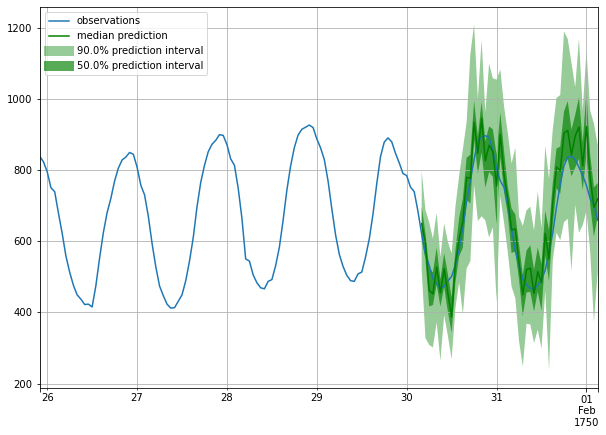

In [28]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [29]:
from gluonts.evaluation import Evaluator

In [30]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 4810.94it/s]


In [31]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 14706843.90478506,
    "abs_error": 11742349.218395233,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 4.849871436554491,
    "MAPE": 0.2807021774771517,
    "sMAPE": 0.21218038287955598,
    "MSIS": 66.39349625925341,
    "QuantileLoss[0.1]": 5561325.933848953,
    "Coverage[0.1]": 0.10024154589371972,
    "QuantileLoss[0.5]": 11742349.28999424,
    "Coverage[0.5]": 0.48918075684380014,
    "QuantileLoss[0.9]": 7599631.881925105,
    "Coverage[0.9]": 0.8737922705313999,
    "RMSE": 3834.950313209424,
    "NRMSE": 0.5235554245169456,
    "ND": 0.08067079481119792,
    "wQuantileLoss[0.1]": 0.03820671442686282,
    "wQuantileLoss[0.5]": 0.08067079530308831,
    "wQuantileLoss[0.9]": 0.05221002482424918,
    "mean_absolute_QuantileLoss": 8301102.368589434,
    "mean_wQuantileLoss": 0.05702917818473343,
    "MAE_Coverage": 0.012422839506173252,
    "OWA": NaN
}


In [32]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4112.962240,2361.236084,31644.0,659.250000,42.371302,1.160984,0.075890,0.073904,13.728673,1083.519324,0.000000,2361.235992,0.666667,1516.134058,1.000000
1,1.0,208432.416667,18983.128906,124149.0,2586.437500,165.107988,2.395292,0.158019,0.143170,15.136232,5611.172729,0.250000,18983.127563,0.916667,9324.955420,1.000000
2,2.0,33688.648438,6976.909668,65030.0,1354.791667,78.889053,1.842490,0.100488,0.107650,14.530123,3748.333496,0.000000,6976.909729,0.145833,2447.083447,0.833333
3,3.0,230194.395833,18361.867188,235783.0,4912.145833,258.982249,1.477085,0.078294,0.078778,15.265842,9932.814160,0.020833,18361.866943,0.416667,8604.088086,1.000000
4,4.0,123021.989583,13020.044922,131088.0,2731.000000,200.494083,1.352912,0.100803,0.096137,12.833074,4656.578735,0.020833,13020.044678,0.770833,8132.835742,1.000000


In [34]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4112.962240,2361.236084,31644.0,659.250000,42.371302,1.160984,0.075890,0.073904,13.728673,1083.519324,0.000000,2361.235992,0.666667,1516.134058,1.000000
1,1.0,208432.416667,18983.128906,124149.0,2586.437500,165.107988,2.395292,0.158019,0.143170,15.136232,5611.172729,0.250000,18983.127563,0.916667,9324.955420,1.000000
2,2.0,33688.648438,6976.909668,65030.0,1354.791667,78.889053,1.842490,0.100488,0.107650,14.530123,3748.333496,0.000000,6976.909729,0.145833,2447.083447,0.833333
3,3.0,230194.395833,18361.867188,235783.0,4912.145833,258.982249,1.477085,0.078294,0.078778,15.265842,9932.814160,0.020833,18361.866943,0.416667,8604.088086,1.000000
4,4.0,123021.989583,13020.044922,131088.0,2731.000000,200.494083,1.352912,0.100803,0.096137,12.833074,4656.578735,0.020833,13020.044678,0.770833,8132.835742,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409.0,1626.881185,1509.715820,5665.0,118.020833,24.726496,1.272013,0.327599,0.336622,12.939783,586.481643,0.145833,1509.715822,0.395833,1270.433980,0.562500
410,410.0,1095.832682,1133.567749,4968.0,103.500000,20.766026,1.137242,0.309567,0.275671,11.285438,635.705014,0.187500,1133.567754,0.562500,640.057166,0.833333
411,411.0,1228.257406,1164.328369,3232.0,67.333333,17.477564,1.387885,0.462649,0.374283,12.639174,1002.187608,0.375000,1164.328333,0.687500,414.694429,0.895833
412,412.0,234.985636,528.881592,2077.0,43.270833,8.636752,1.275753,0.299187,0.262081,11.247131,231.217443,0.229167,528.881601,0.562500,373.525727,0.833333


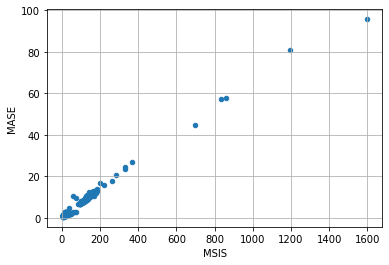

In [33]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()